In [1]:
import os.path
import fnmatch
import nvidia.dali.ops as ops
import nvidia.dali.types as types
from nvidia.dali.pipeline import Pipeline
image_dir = "/home/fhw/amc/dataset/imagenet/train"


In [ ]:
for root, dir, files in os.walk(image_dir):
        depth = root.count('/')
        ret = ""
        if depth > 0:
            ret += "  " * (depth - 1) + "|-"
        print (ret + root)
        for items in fnmatch.filter(files, "*"):
                print (" " * len(ret) + "|-" + items)

In [9]:
class SimplePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(SimplePipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.FileReader(file_root = image_dir)
        # instead of path to file directory file with pairs image_name image_label_value can be provided
        # self.input = ops.FileReader(file_root = image_dir, file_list = image_dir + '/file_list.txt')
        self.decode = ops.ImageDecoder(device = 'cpu', output_type = types.RGB)
        self.res = ops.RandomResizedCrop(device="cpu", size=224, random_area=[0.2, 1.0])
        self.cmnp = ops.CropMirrorNormalize(device="cpu",
                                            output_dtype=types.FLOAT,
                                            output_layout=types.NCHW,
                                            image_type=types.RGB,
                                            mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
                                            std=[0.229 * 255, 0.224 * 255, 0.225 * 255])
        self.coin = ops.CoinFlip(probability=0.5)
#        self.norm = ops.Normalize(device="cpu",mean=[0.485, 0.456, 0.406], stddev=[0.229, 0.224, 0.225])
#        self.flip = ops.Flip(device="cpu")

    def define_graph(self):
        rng = self.coin()
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        images = self.res(images)
        images = self.cmnp(images, mirror=rng)
#        images = self.flip(images, horizontal = rng)
#        images = self.norm(images)
        return (images, labels)

class HybridPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, img_root = image_dir):
        super(HybridPipeline, self).__init__(batch_size, num_threads, device_id)#, seed = 12
        self.input = ops.FileReader(file_root = img_root, random_shuffle=True)
        self.decode = ops.ImageDecoder(device = "mixed", output_type = types.RGB)
        self.res = ops.RandomResizedCrop(device="gpu", size=224, random_area=[0.2, 1.0])
        self.cmnp = ops.CropMirrorNormalize(device="gpu",
                                            dtype=types.FLOAT,
                                            output_layout=types.NCHW,
                                            mean=[0.485*255, 0.456*255, 0.406*255],
                                            std=[0.229*255, 0.224*255, 0.225*255])
        self.coin = ops.CoinFlip(probability=0.5)
#        self.norm = ops.Normalize(device="gpu", mean=[[0.485, 0.456, 0.406]], stddev=[[0.229, 0.224, 0.225]])
#        self.flip = ops.Flip(device="gpu")

    def define_graph(self):
        rng = self.coin()
        jpegs, labels = self.input()
        images = self.decode(jpegs)
        images = self.res(images)
        images = self.cmnp(images, mirror=rng)
        # images are on the GPU
        return (images, labels)

In [3]:
from timeit import default_timer as timer

test_batch_size = 256

def speedtest(pipeclass, batch, n_threads):
    pipe = pipeclass(batch, n_threads, 0)
    pipe.build()
    # warmup
    for i in range(5):
        pipe.run()
    # test
    n_test = 20
    t_start = timer()
    for i in range(n_test):
        pipe.run()
    t = timer() - t_start
    print("Speed: {} imgs/s".format((n_test * batch)/t))

In [4]:
import torch
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

import os


def get_dataset(dset_name, batch_size, n_worker, data_root=image_dir):
    cifar_tran_train = [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
    cifar_tran_test = [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
    print('=> Preparing data..')
    if dset_name == 'cifar10':
        transform_train = transforms.Compose(cifar_tran_train)
        transform_test = transforms.Compose(cifar_tran_test)
        trainset = torchvision.datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform_train)
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,
                                                   num_workers=n_worker, pin_memory=True, sampler=None)
        testset = torchvision.datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform_test)
        val_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False,
                                                 num_workers=n_worker, pin_memory=True)
        n_class = 10
    elif dset_name == 'imagenet':
        # get dir
        traindir = data_root
#        valdir = data_root

        # preprocessing
        input_size = 224
        imagenet_tran_train = [
            transforms.RandomResizedCrop(input_size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
        imagenet_tran_test = [
            transforms.Resize(int(input_size / 0.875)),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]

        train_loader = torch.utils.data.DataLoader(
            datasets.ImageFolder(traindir, transforms.Compose(imagenet_tran_train)),
            batch_size=batch_size, shuffle=True,
            num_workers=n_worker, pin_memory=True, sampler=None)
        val_loader = None
#        val_loader = torch.utils.data.DataLoader(
#            datasets.ImageFolder(valdir, transforms.Compose(imagenet_tran_test)),
#            batch_size=batch_size, shuffle=True,
#            num_workers=n_worker, pin_memory=True)
        n_class = 1000

    else:
        raise NotImplementedError

    return train_loader, val_loader, n_class


In [5]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
test_batch_size = 256

speedtest(HybridPipeline, test_batch_size, 6)

Speed: 2678.4153808554697 imgs/s


In [7]:
train_loader, val_loader, n_class = get_dataset('imagenet', 256, 6)

=> Preparing data..


In [8]:
for batch_idx, (inputs, targets) in enumerate(train_loader):
    if batch_idx == 5:
        t_start = timer()
    inputs, targets = inputs.cuda(), targets.cuda()
    if batch_idx == 24:
        t = timer() - t_start
        print("Speed: {} imgs/s".format((20 * 256)/t))
        break


Speed: 710.3904233763475 imgs/s


=> Preparing data..
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
0
torch.Size([1, 3, 224, 224])
1
torch.Size([1, 3, 224, 224])
2
torch.Size([1, 3, 224, 224])
3
torch.Size([1, 3, 224, 224])


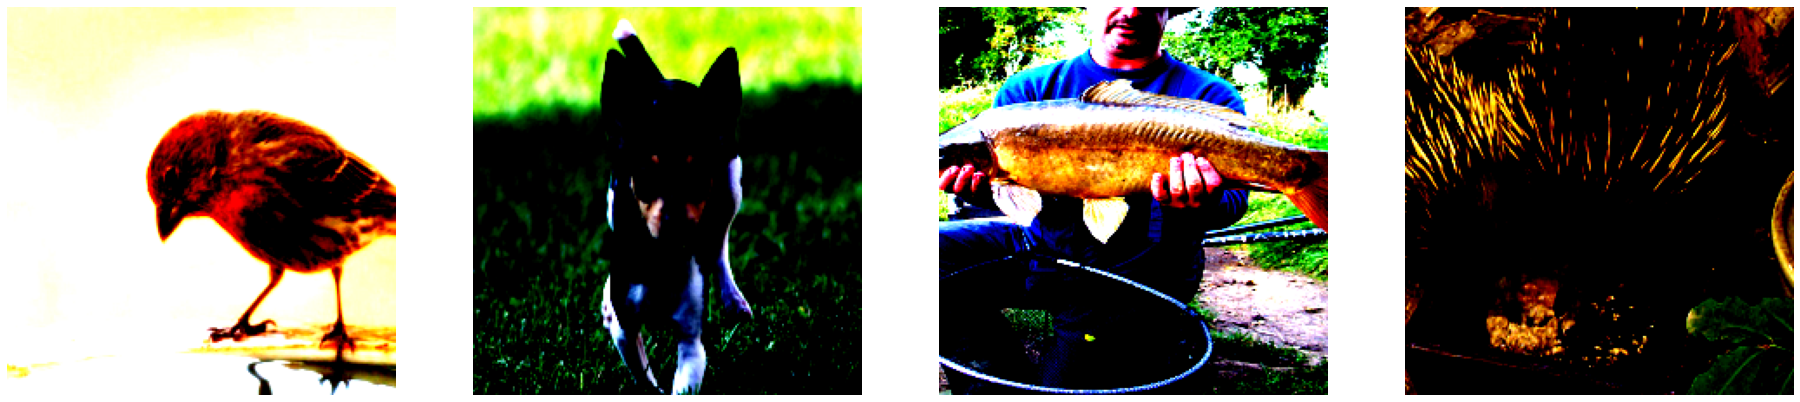

In [15]:
train_loader, val_loader, n_class = get_dataset('imagenet', 1, 1, data_root="/home/fhw/amc/dali/pic")
columns = 4
rows = 1
fig = plt.figure(figsize = (32,(32 // columns) * rows))
gs = gridspec.GridSpec(rows, columns)
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(batch_idx)
    print(inputs.shape)
    array = np.array(inputs[0])
    img = np.transpose(array, (1, 2, 0)) * 256  # 长宽通道数
    img = img.astype(np.int)
    plt.subplot(gs[batch_idx])
    plt.axis("off")
    plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
4


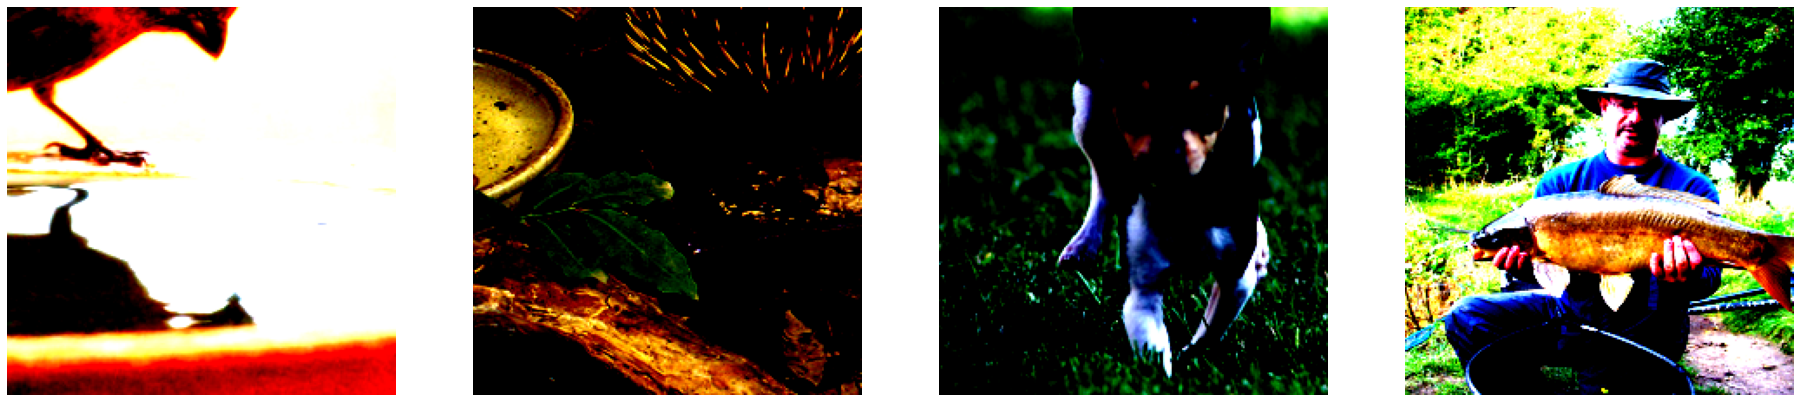

In [14]:
batch_size = 4
pipe = HybridPipeline(batch_size=batch_size, num_threads=1, device_id = 0, img_root="/home/fhw/amc/dali/pic")
pipe.build()
pipe_out = pipe.run()
import math
import numpy as np
img_chw, labels = pipe_out
len_outputs = len(img_chw)
columns = 4
rows = 1
fig = plt.figure(figsize = (32,(32 // columns) * rows))
gs = gridspec.GridSpec(rows, columns)
print(len_outputs)
img_chw = img_chw.as_cpu()
#print(img_chw)
#shape = img_chw.shape
#print(shape)
for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        array = np.array(img_chw.at(j))
        img = np.transpose(array, (1, 2, 0)) * 256  # 长宽通道数
        img = img.astype(np.int)
        plt.imshow(img)
